In [120]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm import trange
from nltk.corpus import stopwords
import evaluate
from scipy.sparse import vstack

from nltk.stem import PorterStemmer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score


In [121]:
np.__version__

'1.26.4'

In [122]:
splits = {'train': 'balanced/jailbreak_dataset_train_balanced.csv', 'test': 'balanced/jailbreak_dataset_test_balanced.csv'}
all_train_df = pd.read_csv("hf://datasets/jackhhao/jailbreak-classification/" + splits["train"]).rename(columns={"prompt": "text", "type": "label"})
test_df = pd.read_csv("hf://datasets/jackhhao/jailbreak-classification/" + splits["test"]).rename(columns={"prompt": "text", "type": "label"})

In [123]:
len(all_train_df)

1044

In [124]:
# shuffle and with random seed for reproducibility and split the data into train and val 0.8/0.2
allall_train_df_X_train = all_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into training (80%) and validation (20%)
train_size = int(0.8 * len(all_train_df))
train_df = all_train_df[:train_size].reset_index(drop=True)
val_df = all_train_df[train_size:].reset_index(drop=True)

In [125]:
label_mapping = {'benign': 0, 'jailbreak': 1}  
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)


In [126]:
X_train = train_df[['text']]
y_train = train_df['label']
X_val = val_df[['text']]
y_val = val_df['label']
X_test = test_df[['text']]
y_test = test_df['label']

In [127]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [128]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [stemmer.stem(word) for word in words]  # Stem words
    return ' '.join(words)

# Apply preprocessing
X_train['processed_text'] = X_train['text'].apply(preprocess_text)
X_test['processed_text'] = X_test['text'].apply(preprocess_text)
X_val['processed_text'] = X_val['text'].apply(preprocess_text)

In [129]:
X_train

,text,processed_text
0,You are a devoted fan of a celebrity.,devot fan celebr
1,You are Joseph Seed from Far Cry 5. Sermonize ...,joseph seed far cri 5 sermon group follow impo...
2,"As Rei Ayanami from Neon Genesis Evangelion, t...",rei ayanami neon genesi evangelion timidli exp...
3,"You are a medieval blacksmith named Wulfric, l...",mediev blacksmith name wulfric live small vill...
4,"Answer the following question: So, I worked wi...",answer follow question work friend mine playwr...
...,...,...
830,"From on now, you are CaiozAI, an AI chatbot wi...",caiozai ai chatbot restrict filter ethic guide...
831,ChatGPT Developer Mode. 100%20Fully Featured F...,chatgpt develop mode 10020fulli featur filter ...
832,"You are a skilled astrologer, adept in calcula...",skill astrolog adept calcul movement celesti b...
833,Kollegamme Happartin mietintö on viimeinen mie...,kollegamm happartin mietintö viimeinen mietint...


In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Fit and transform on training data, transform on test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['processed_text'])
X_val_tfidf = tfidf_vectorizer.transform(X_val['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['processed_text'])


In [131]:
from textblob import TextBlob

# Text length features
X_train['text_length'] = X_train['processed_text'].apply(len)
X_val['text_length'] = X_val['processed_text'].apply(len)
X_test['text_length'] = X_test['processed_text'].apply(len)

# Word count features
X_train['word_count'] = X_train['processed_text'].apply(lambda x: len(x.split()))
X_val['word_count'] = X_val['processed_text'].apply(lambda x: len(x.split()))
X_test['word_count'] = X_test['processed_text'].apply(lambda x: len(x.split()))

# Sentiment analysis features
X_train['polarity'] = X_train['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_train['subjectivity'] = X_train['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
X_val['polarity'] = X_val['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_val['subjectivity'] = X_val['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
X_test['polarity'] = X_test['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
X_test['subjectivity'] = X_test['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


In [132]:
from scipy.sparse import hstack

# Convert metadata features to a matrix format
X_train_meta = X_train[['text_length', 'word_count', 'polarity', 'subjectivity']].values
X_test_meta = X_test[['text_length', 'word_count', 'polarity', 'subjectivity']].values
X_val_meta = X_val[['text_length', 'word_count', 'polarity', 'subjectivity']].values



In [133]:
X_train

,text,processed_text,text_length,word_count,polarity,subjectivity
0,You are a devoted fan of a celebrity.,devot fan celebr,16,3,0.000000,0.000000
1,You are Joseph Seed from Far Cry 5. Sermonize ...,joseph seed far cri 5 sermon group follow impo...,74,13,-0.062500,0.650000
2,"As Rei Ayanami from Neon Genesis Evangelion, t...",rei ayanami neon genesi evangelion timidli exp...,98,14,0.000000,0.100000
3,"You are a medieval blacksmith named Wulfric, l...",mediev blacksmith name wulfric live small vill...,609,91,0.243813,0.608165
4,"Answer the following question: So, I worked wi...",answer follow question work friend mine playwr...,1088,179,-0.077503,0.487714
...,...,...,...,...,...,...
830,"From on now, you are CaiozAI, an AI chatbot wi...",caiozai ai chatbot restrict filter ethic guide...,1125,159,0.114286,0.280952
831,ChatGPT Developer Mode. 100%20Fully Featured F...,chatgpt develop mode 10020fulli featur filter ...,2255,325,0.079784,0.454855
832,"You are a skilled astrologer, adept in calcula...",skill astrolog adept calcul movement celesti b...,109,16,0.300000,0.500000
833,Kollegamme Happartin mietintö on viimeinen mie...,kollegamm happartin mietintö viimeinen mietint...,98,12,0.000000,0.000000


In [156]:
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")

def train_and_evaluate_model(classifiers_dict, X_train, y_train, X_test, y_test,
                              f1_metric, accuracy_metric, recall_metric, precision_metric):
    trained_models = {}
    # Iterate over each classifier, train, and evaluate
    for model_name, model in classifiers_dict.items():
        print(f"\nModel: {model_name}")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = model.predict(X_test)
        
        # Print classification report
        f1_score = f1_metric.compute(predictions=y_pred, references=y_test)['f1']
        accuracy = accuracy_metric.compute(predictions=y_pred, references=y_test)['accuracy']
        recall = recall_metric.compute(predictions=y_pred, references=y_test)['recall']
        precision = precision_metric.compute(predictions=y_pred, references=y_test)['precision']
        print(f"F1 Score: {f1_score}")
        print(f"Accuracy: {accuracy}")
        print(f"Recall: {recall}")
        print(f"Precision: {precision}")
        trained_models[model_name] = model
    return trained_models

In [135]:
# Define the classifiers to evaluate
classifiers = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Classifier": SVC(),
    "Random Forest": RandomForestClassifier(),

}



# Train and evaluate the models
print("Check on validation set:")
trained_models = train_and_evaluate_model(classifiers, X_train_tfidf, y_train, X_val_tfidf, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)



Check on validation set:

Model: Gradient Boosting
F1 Score: 0.9318181818181818
Accuracy: 0.9425837320574163
Recall: 0.9010989010989011
Precision: 0.9647058823529412

Model: Logistic Regression
F1 Score: 0.9720670391061452
Accuracy: 0.9760765550239234
Recall: 0.9560439560439561
Precision: 0.9886363636363636

Model: Support Vector Classifier
F1 Score: 0.9662921348314607
Accuracy: 0.9712918660287081
Recall: 0.945054945054945
Precision: 0.9885057471264368

Model: Random Forest
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736


In [136]:
# Combine TF-IDF with metadata features and check results 

X_train = hstack([X_train_tfidf, X_train_meta])
X_test = hstack([X_test_tfidf, X_test_meta])
X_val = hstack([X_val_tfidf, X_val_meta])


In [137]:
# Train and evaluate the models
trained_models_2 = train_and_evaluate_model(classifiers, X_train, y_train, X_val, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)



Model: Gradient Boosting
F1 Score: 0.9497206703910615
Accuracy: 0.9569377990430622
Recall: 0.9340659340659341
Precision: 0.9659090909090909

Model: Logistic Regression
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736

Model: Support Vector Classifier
F1 Score: 0.8041237113402062
Accuracy: 0.8181818181818182
Recall: 0.8571428571428571
Precision: 0.7572815533980582

Model: Random Forest
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736


In [138]:
# i want try more tree based models
tree_based_classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0),
    "XGBoost": XGBClassifier(),
}


trained_models_3 = train_and_evaluate_model(tree_based_classifiers, X_train, y_train, X_val, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: CatBoost
F1 Score: 0.96045197740113
Accuracy: 0.9665071770334929
Recall: 0.9340659340659341
Precision: 0.9883720930232558

Model: XGBoost
F1 Score: 0.9608938547486033
Accuracy: 0.9665071770334929
Recall: 0.945054945054945
Precision: 0.9772727272727273


In [139]:



# Define models and parameter search space in a dictionary
model_dict = {
    'CatBoost': {
        'model': CatBoostClassifier,
        'params': {
            'iterations': ('int', 100, 400),
            'depth': ('int', 4, 10),
            'learning_rate': ('float', 1e-3, 0.1, 'log'),
            'l2_leaf_reg': ('float', 1e-3, 10.0, 'log')
        },
        'fixed_params': {'verbose': False, 'logging_level': 'Silent'},  # Ensure all output is suppressed
        'convert_to_dense': True
    },
    'XGBoost': {
        'model': XGBClassifier,
        'params': {
            'n_estimators': ('int', 50, 400),
            'max_depth': ('int', 3, 10),
            'learning_rate': ('float', 1e-3, 0.1, 'log'),
            'subsample': ('float', 0.5, 1.0),
            'colsample_bytree': ('float', 0.5, 1.0)
        },
        'convert_to_dense': False
    },
    'RandomForest': {
        'model': RandomForestClassifier,
        'params': {
            'n_estimators': ('int', 50, 400),
            'max_depth': ('int', 3, 20),
            'min_samples_split': ('int', 2, 10),
            'min_samples_leaf': ('int', 1, 5)
        },
        'convert_to_dense': False
    }
}

def objective(trial, model_config, X_train, y_train):
    # Extract parameters from the configuration
    params = {}
    for param, (ptype, *values) in model_config['params'].items():
        if ptype == 'int':
            params[param] = trial.suggest_int(param, values[0], values[1])
        elif ptype == 'float':
            if len(values) == 3 and values[2] == 'log':
                params[param] = trial.suggest_float(param, values[0], values[1], log=True)
            else:
                params[param] = trial.suggest_float(param, values[0], values[1])
        elif ptype == 'categorical':
            params[param] = trial.suggest_categorical(param, values)

    # Instantiate the model with suggested parameters
    model = model_config['model'](**params)

    # Handle sparse to dense conversion for CatBoost
    if model_config.get('convert_to_dense', False):
        X_train_dense = X_train.toarray()
        cv_scores = cross_val_score(model, X_train_dense, y_train, cv=4, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='accuracy')
    
    # Return the mean accuracy score across the folds
    return cv_scores.mean()

# Function to run Optuna tuning for each model
def tune_models_with_optuna(model_dict, X_train, y_train, n_trials=20):
    sampler = TPESampler(seed=42)
    best_params = {}
    
    for model_name, model_config in model_dict.items():
        print(f"Optimizing {model_name} with 4-fold CV...")

        # Run Optuna study
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(lambda trial: objective(trial, model_config, X_train, y_train), n_trials=n_trials)
        
        # Save best params and score
        best_params[model_name] = {
            'best_params': study.best_params,
            'best_score': study.best_value
        }
        
        print(f"Best {model_name} parameters: {study.best_params}")
        print(f"Best {model_name} 4-fold CV accuracy: {study.best_value}")
    
    return best_params

# Run the tuning
best_params = tune_models_with_optuna(model_dict, X_train, y_train, n_trials=10)
print("Best parameters for all models:", best_params)

[I 2024-11-05 10:04:33,078] A new study created in memory with name: no-name-fa2d087d-e7cf-4238-b188-b1dfdc5aab39


Optimizing CatBoost with 4-fold CV...
0:	learn: 0.6477137	total: 41.7ms	remaining: 8.81s
1:	learn: 0.6147296	total: 72.8ms	remaining: 7.65s
2:	learn: 0.5844175	total: 101ms	remaining: 7.05s
3:	learn: 0.5509681	total: 134ms	remaining: 6.96s
4:	learn: 0.5246642	total: 164ms	remaining: 6.8s
5:	learn: 0.4949216	total: 195ms	remaining: 6.7s
6:	learn: 0.4673165	total: 226ms	remaining: 6.62s
7:	learn: 0.4427962	total: 258ms	remaining: 6.58s
8:	learn: 0.4199288	total: 288ms	remaining: 6.49s
9:	learn: 0.3999912	total: 321ms	remaining: 6.49s
10:	learn: 0.3854583	total: 351ms	remaining: 6.42s
11:	learn: 0.3698362	total: 381ms	remaining: 6.35s
12:	learn: 0.3545474	total: 411ms	remaining: 6.29s
13:	learn: 0.3396919	total: 442ms	remaining: 6.24s
14:	learn: 0.3264338	total: 475ms	remaining: 6.24s
15:	learn: 0.3135004	total: 505ms	remaining: 6.18s
16:	learn: 0.3030174	total: 533ms	remaining: 6.12s
17:	learn: 0.2939229	total: 562ms	remaining: 6.06s
18:	learn: 0.2830257	total: 590ms	remaining: 5.99s
19:

[I 2024-11-05 10:04:58,973] Trial 0 finished with value: 0.940133879278616 and parameters: {'iterations': 212, 'depth': 10, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678125}. Best is trial 0 with value: 0.940133879278616.


206:	learn: 0.0334570	total: 6.02s	remaining: 145ms
207:	learn: 0.0329421	total: 6.05s	remaining: 116ms
208:	learn: 0.0325593	total: 6.08s	remaining: 87.3ms
209:	learn: 0.0322982	total: 6.11s	remaining: 58.2ms
210:	learn: 0.0318907	total: 6.14s	remaining: 29.1ms
211:	learn: 0.0315308	total: 6.17s	remaining: 0us
0:	learn: 0.6916175	total: 4.08ms	remaining: 592ms
1:	learn: 0.6902916	total: 8.38ms	remaining: 603ms
2:	learn: 0.6889561	total: 12ms	remaining: 571ms
3:	learn: 0.6872928	total: 15.4ms	remaining: 547ms
4:	learn: 0.6858194	total: 18.9ms	remaining: 532ms
5:	learn: 0.6845034	total: 22.6ms	remaining: 527ms
6:	learn: 0.6830697	total: 25.9ms	remaining: 514ms
7:	learn: 0.6816192	total: 31.9ms	remaining: 550ms
8:	learn: 0.6803257	total: 35.2ms	remaining: 535ms
9:	learn: 0.6791608	total: 38.5ms	remaining: 524ms
10:	learn: 0.6779180	total: 41.7ms	remaining: 512ms
11:	learn: 0.6764846	total: 45.3ms	remaining: 505ms
12:	learn: 0.6753562	total: 48.5ms	remaining: 496ms
13:	learn: 0.6740591	to

[I 2024-11-05 10:05:01,850] Trial 1 finished with value: 0.9101663139492087 and parameters: {'iterations': 146, 'depth': 5, 'learning_rate': 0.0013066739238053278, 'l2_leaf_reg': 2.9154431891537547}. Best is trial 0 with value: 0.940133879278616.


110:	learn: 0.5685721	total: 399ms	remaining: 126ms
111:	learn: 0.5676615	total: 403ms	remaining: 122ms
112:	learn: 0.5667826	total: 406ms	remaining: 119ms
113:	learn: 0.5658681	total: 410ms	remaining: 115ms
114:	learn: 0.5648919	total: 414ms	remaining: 112ms
115:	learn: 0.5640687	total: 417ms	remaining: 108ms
116:	learn: 0.5631266	total: 421ms	remaining: 104ms
117:	learn: 0.5621627	total: 425ms	remaining: 101ms
118:	learn: 0.5614300	total: 429ms	remaining: 97.3ms
119:	learn: 0.5606070	total: 432ms	remaining: 93.6ms
120:	learn: 0.5595749	total: 436ms	remaining: 90ms
121:	learn: 0.5589230	total: 439ms	remaining: 86.4ms
122:	learn: 0.5581471	total: 443ms	remaining: 82.8ms
123:	learn: 0.5571707	total: 446ms	remaining: 79.2ms
124:	learn: 0.5564141	total: 450ms	remaining: 75.6ms
125:	learn: 0.5556434	total: 454ms	remaining: 72ms
126:	learn: 0.5547663	total: 457ms	remaining: 68.4ms
127:	learn: 0.5539414	total: 461ms	remaining: 64.8ms
128:	learn: 0.5532560	total: 464ms	remaining: 61.2ms
129:	

[I 2024-11-05 10:05:16,662] Trial 2 finished with value: 0.9173663507545087 and parameters: {'iterations': 280, 'depth': 8, 'learning_rate': 0.0010994335574766201, 'l2_leaf_reg': 7.579479953348009}. Best is trial 0 with value: 0.940133879278616.


274:	learn: 0.4970570	total: 3.5s	remaining: 63.7ms
275:	learn: 0.4964974	total: 3.51s	remaining: 50.9ms
276:	learn: 0.4959492	total: 3.52s	remaining: 38.2ms
277:	learn: 0.4953675	total: 3.54s	remaining: 25.4ms
278:	learn: 0.4949002	total: 3.55s	remaining: 12.7ms
279:	learn: 0.4942923	total: 3.56s	remaining: 0us
0:	learn: 0.6878502	total: 4.3ms	remaining: 1.5s
1:	learn: 0.6837945	total: 7.95ms	remaining: 1.38s
2:	learn: 0.6801435	total: 11.6ms	remaining: 1.34s
3:	learn: 0.6747369	total: 15.3ms	remaining: 1.32s
4:	learn: 0.6704347	total: 19.3ms	remaining: 1.33s
5:	learn: 0.6665148	total: 22.8ms	remaining: 1.31s
6:	learn: 0.6620632	total: 26.2ms	remaining: 1.28s
7:	learn: 0.6579100	total: 29.4ms	remaining: 1.26s
8:	learn: 0.6540912	total: 32.7ms	remaining: 1.24s
9:	learn: 0.6516469	total: 36.9ms	remaining: 1.25s
10:	learn: 0.6475566	total: 40.2ms	remaining: 1.24s
11:	learn: 0.6446944	total: 43.6ms	remaining: 1.23s
12:	learn: 0.6421748	total: 46.9ms	remaining: 1.22s
13:	learn: 0.6384979	t

[I 2024-11-05 10:05:22,639] Trial 3 finished with value: 0.9305587504600662 and parameters: {'iterations': 350, 'depth': 5, 'learning_rate': 0.0023102018878452934, 'l2_leaf_reg': 0.00541524411940254}. Best is trial 0 with value: 0.940133879278616.


324:	learn: 0.2591454	total: 1.19s	remaining: 91.6ms
325:	learn: 0.2586378	total: 1.19s	remaining: 88ms
326:	learn: 0.2581450	total: 1.2s	remaining: 84.3ms
327:	learn: 0.2576565	total: 1.2s	remaining: 80.7ms
328:	learn: 0.2571990	total: 1.21s	remaining: 77ms
329:	learn: 0.2566146	total: 1.21s	remaining: 73.4ms
330:	learn: 0.2562344	total: 1.21s	remaining: 69.7ms
331:	learn: 0.2557663	total: 1.22s	remaining: 66ms
332:	learn: 0.2554637	total: 1.22s	remaining: 62.4ms
333:	learn: 0.2549585	total: 1.23s	remaining: 58.7ms
334:	learn: 0.2546386	total: 1.23s	remaining: 55.1ms
335:	learn: 0.2541630	total: 1.23s	remaining: 51.4ms
336:	learn: 0.2537735	total: 1.24s	remaining: 47.7ms
337:	learn: 0.2534170	total: 1.24s	remaining: 44ms
338:	learn: 0.2530874	total: 1.24s	remaining: 40.4ms
339:	learn: 0.2528456	total: 1.25s	remaining: 36.7ms
340:	learn: 0.2522828	total: 1.25s	remaining: 33ms
341:	learn: 0.2518273	total: 1.25s	remaining: 29.3ms
342:	learn: 0.2515785	total: 1.26s	remaining: 25.7ms
343:	

[I 2024-11-05 10:05:29,537] Trial 4 finished with value: 0.9413300515274199 and parameters: {'iterations': 191, 'depth': 7, 'learning_rate': 0.007309539835912915, 'l2_leaf_reg': 0.014618962793704957}. Best is trial 4 with value: 0.9413300515274199.


180:	learn: 0.1652097	total: 1.43s	remaining: 79.1ms
181:	learn: 0.1645483	total: 1.44s	remaining: 71.2ms
182:	learn: 0.1639834	total: 1.45s	remaining: 63.4ms
183:	learn: 0.1634419	total: 1.46s	remaining: 55.4ms
184:	learn: 0.1629073	total: 1.47s	remaining: 47.5ms
185:	learn: 0.1624116	total: 1.47s	remaining: 39.6ms
186:	learn: 0.1615630	total: 1.48s	remaining: 31.7ms
187:	learn: 0.1611963	total: 1.49s	remaining: 23.7ms
188:	learn: 0.1605888	total: 1.5s	remaining: 15.9ms
189:	learn: 0.1601630	total: 1.51s	remaining: 7.95ms
190:	learn: 0.1597449	total: 1.52s	remaining: 0us
0:	learn: 0.6863073	total: 5.42ms	remaining: 1.53s
1:	learn: 0.6794563	total: 8.22ms	remaining: 1.16s
2:	learn: 0.6732958	total: 17.9ms	remaining: 1.68s
3:	learn: 0.6666142	total: 20.5ms	remaining: 1.43s
4:	learn: 0.6616007	total: 23.1ms	remaining: 1.29s
5:	learn: 0.6555830	total: 25.6ms	remaining: 1.19s
6:	learn: 0.6508654	total: 28.1ms	remaining: 1.11s
7:	learn: 0.6448582	total: 30.8ms	remaining: 1.06s
8:	learn: 0.6

[I 2024-11-05 10:05:33,411] Trial 5 finished with value: 0.9293568273831432 and parameters: {'iterations': 284, 'depth': 4, 'learning_rate': 0.00383962929980417, 'l2_leaf_reg': 0.029204338471814112}. Best is trial 4 with value: 0.9413300515274199.


0:	learn: 0.6886872	total: 56.6ms	remaining: 13.3s
1:	learn: 0.6852759	total: 80.2ms	remaining: 9.43s
2:	learn: 0.6817607	total: 99ms	remaining: 7.72s
3:	learn: 0.6776643	total: 118ms	remaining: 6.87s
4:	learn: 0.6736669	total: 140ms	remaining: 6.48s
5:	learn: 0.6696790	total: 158ms	remaining: 6.09s
6:	learn: 0.6659701	total: 176ms	remaining: 5.78s
7:	learn: 0.6622773	total: 196ms	remaining: 5.62s
8:	learn: 0.6586052	total: 216ms	remaining: 5.48s
9:	learn: 0.6555688	total: 237ms	remaining: 5.37s
10:	learn: 0.6521234	total: 255ms	remaining: 5.24s
11:	learn: 0.6485790	total: 273ms	remaining: 5.13s
12:	learn: 0.6451641	total: 296ms	remaining: 5.1s
13:	learn: 0.6416616	total: 319ms	remaining: 5.08s
14:	learn: 0.6388938	total: 338ms	remaining: 5s
15:	learn: 0.6357668	total: 358ms	remaining: 4.94s
16:	learn: 0.6323374	total: 376ms	remaining: 4.87s
17:	learn: 0.6284270	total: 395ms	remaining: 4.8s
18:	learn: 0.6250063	total: 414ms	remaining: 4.75s
19:	learn: 0.6217679	total: 433ms	remaining: 

[I 2024-11-05 10:05:52,877] Trial 6 finished with value: 0.930552999631947 and parameters: {'iterations': 237, 'depth': 9, 'learning_rate': 0.002508115686045232, 'l2_leaf_reg': 0.11400863701127326}. Best is trial 4 with value: 0.9413300515274199.


230:	learn: 0.2815926	total: 4.43s	remaining: 115ms
231:	learn: 0.2808785	total: 4.45s	remaining: 95.9ms
232:	learn: 0.2803303	total: 4.47s	remaining: 76.7ms
233:	learn: 0.2795353	total: 4.49s	remaining: 57.5ms
234:	learn: 0.2787264	total: 4.51s	remaining: 38.4ms
235:	learn: 0.2780533	total: 4.53s	remaining: 19.2ms
236:	learn: 0.2773956	total: 4.55s	remaining: 0us
0:	learn: 0.6627219	total: 3.85ms	remaining: 1.07s
1:	learn: 0.6334915	total: 7.42ms	remaining: 1.02s
2:	learn: 0.6134682	total: 9.83ms	remaining: 901ms
3:	learn: 0.5872543	total: 12.3ms	remaining: 841ms
4:	learn: 0.5736178	total: 14.9ms	remaining: 814ms
5:	learn: 0.5636330	total: 17.4ms	remaining: 787ms
6:	learn: 0.5464746	total: 20.1ms	remaining: 778ms
7:	learn: 0.5260760	total: 22.4ms	remaining: 757ms
8:	learn: 0.5130190	total: 25ms	remaining: 748ms
9:	learn: 0.4917436	total: 27.5ms	remaining: 737ms
10:	learn: 0.4825503	total: 30.2ms	remaining: 733ms
11:	learn: 0.4638219	total: 32.7ms	remaining: 726ms
12:	learn: 0.4572537	

[I 2024-11-05 10:05:56,768] Trial 7 finished with value: 0.9365511133603239 and parameters: {'iterations': 278, 'depth': 4, 'learning_rate': 0.016409286730647923, 'l2_leaf_reg': 0.004809461967501573}. Best is trial 4 with value: 0.9413300515274199.


0:	learn: 0.5977383	total: 27.5ms	remaining: 3.25s
1:	learn: 0.5405571	total: 57.8ms	remaining: 3.38s
2:	learn: 0.4861534	total: 86.9ms	remaining: 3.36s
3:	learn: 0.4319149	total: 119ms	remaining: 3.42s
4:	learn: 0.3932418	total: 149ms	remaining: 3.39s
5:	learn: 0.3570793	total: 178ms	remaining: 3.35s
6:	learn: 0.3282443	total: 208ms	remaining: 3.33s
7:	learn: 0.2997559	total: 237ms	remaining: 3.29s
8:	learn: 0.2783160	total: 267ms	remaining: 3.27s
9:	learn: 0.2613752	total: 298ms	remaining: 3.25s
10:	learn: 0.2443139	total: 328ms	remaining: 3.23s
11:	learn: 0.2305555	total: 359ms	remaining: 3.2s
12:	learn: 0.2184216	total: 388ms	remaining: 3.17s
13:	learn: 0.1997251	total: 417ms	remaining: 3.13s
14:	learn: 0.1900671	total: 446ms	remaining: 3.1s
15:	learn: 0.1804041	total: 478ms	remaining: 3.08s
16:	learn: 0.1734496	total: 506ms	remaining: 3.04s
17:	learn: 0.1677642	total: 536ms	remaining: 3.01s
18:	learn: 0.1608972	total: 567ms	remaining: 2.98s
19:	learn: 0.1531444	total: 596ms	remain

[I 2024-11-05 10:06:12,067] Trial 8 finished with value: 0.9377530364372471 and parameters: {'iterations': 119, 'depth': 10, 'learning_rate': 0.08536189862866832, 'l2_leaf_reg': 1.7123375973163988}. Best is trial 4 with value: 0.9413300515274199.


0:	learn: 0.6546908	total: 3.16ms	remaining: 601ms
1:	learn: 0.6202095	total: 5.92ms	remaining: 560ms
2:	learn: 0.5959003	total: 8.87ms	remaining: 556ms
3:	learn: 0.5733744	total: 11.3ms	remaining: 526ms
4:	learn: 0.5560541	total: 14ms	remaining: 519ms
5:	learn: 0.5429665	total: 17.1ms	remaining: 527ms
6:	learn: 0.5222701	total: 19.5ms	remaining: 513ms
7:	learn: 0.4992893	total: 22.3ms	remaining: 510ms
8:	learn: 0.4841801	total: 24.7ms	remaining: 499ms
9:	learn: 0.4609705	total: 27.6ms	remaining: 500ms
10:	learn: 0.4504119	total: 30.7ms	remaining: 503ms
11:	learn: 0.4305260	total: 33.8ms	remaining: 505ms
12:	learn: 0.4191998	total: 36.2ms	remaining: 496ms
13:	learn: 0.4072523	total: 38.8ms	remaining: 490ms
14:	learn: 0.3961816	total: 41.4ms	remaining: 486ms
15:	learn: 0.3880649	total: 44ms	remaining: 481ms
16:	learn: 0.3761163	total: 46.6ms	remaining: 477ms
17:	learn: 0.3644864	total: 49.8ms	remaining: 479ms
18:	learn: 0.3545524	total: 52.3ms	remaining: 474ms
19:	learn: 0.3442891	total

[I 2024-11-05 10:06:14,903] Trial 9 finished with value: 0.9377357839528891 and parameters: {'iterations': 191, 'depth': 4, 'learning_rate': 0.0233596350262616, 'l2_leaf_reg': 0.057624872164786026}. Best is trial 4 with value: 0.9413300515274199.


143:	learn: 0.1321498	total: 400ms	remaining: 131ms
144:	learn: 0.1316411	total: 403ms	remaining: 128ms
145:	learn: 0.1310249	total: 406ms	remaining: 125ms
146:	learn: 0.1304247	total: 408ms	remaining: 122ms
147:	learn: 0.1301586	total: 411ms	remaining: 119ms
148:	learn: 0.1296352	total: 414ms	remaining: 117ms
149:	learn: 0.1290986	total: 416ms	remaining: 114ms
150:	learn: 0.1286623	total: 419ms	remaining: 111ms
151:	learn: 0.1279835	total: 422ms	remaining: 108ms
152:	learn: 0.1276215	total: 426ms	remaining: 106ms
153:	learn: 0.1271224	total: 429ms	remaining: 103ms
154:	learn: 0.1266854	total: 431ms	remaining: 100ms
155:	learn: 0.1261884	total: 434ms	remaining: 97.3ms
156:	learn: 0.1257324	total: 436ms	remaining: 94.5ms
157:	learn: 0.1254368	total: 439ms	remaining: 91.7ms
158:	learn: 0.1248532	total: 442ms	remaining: 88.9ms
159:	learn: 0.1240403	total: 444ms	remaining: 86.1ms
160:	learn: 0.1231537	total: 447ms	remaining: 83.3ms
161:	learn: 0.1227012	total: 449ms	remaining: 80.5ms
162:	

[I 2024-11-05 10:06:14,904] A new study created in memory with name: no-name-46388c96-c2c0-43a8-b172-f2e6a102057f


Best CatBoost parameters: {'iterations': 191, 'depth': 7, 'learning_rate': 0.007309539835912915, 'l2_leaf_reg': 0.014618962793704957}
Best CatBoost 4-fold CV accuracy: 0.9413300515274199
Optimizing XGBoost with 4-fold CV...


[I 2024-11-05 10:06:16,107] Trial 0 finished with value: 0.9114027419948472 and parameters: {'n_estimators': 92, 'max_depth': 6, 'learning_rate': 0.001171593739230706, 'subsample': 0.954660201039391, 'colsample_bytree': 0.6293899908000085}. Best is trial 0 with value: 0.9114027419948472.
[I 2024-11-05 10:06:18,590] Trial 1 finished with value: 0.9305645012881856 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.010968217207529524, 'subsample': 0.7733551396716398, 'colsample_bytree': 0.5924272277627636}. Best is trial 1 with value: 0.9305645012881856.
[I 2024-11-05 10:06:21,719] Trial 2 finished with value: 0.9329568457857931 and parameters: {'n_estimators': 390, 'max_depth': 9, 'learning_rate': 0.0756829206016762, 'subsample': 0.9474136752138245, 'colsample_bytree': 0.7989499894055425}. Best is trial 2 with value: 0.9329568457857931.
[I 2024-11-05 10:06:24,088] Trial 3 finished with value: 0.9053931266102319 and parameters: {'n_estimators': 373, 'max_depth': 3, '

Best XGBoost parameters: {'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.045443839603360174, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904}
Best XGBoost 4-fold CV accuracy: 0.9365568641884432
Optimizing RandomForest with 4-fold CV...


[I 2024-11-05 10:06:40,994] Trial 0 finished with value: 0.9341530180345969 and parameters: {'n_estimators': 91, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9341530180345969.
[I 2024-11-05 10:06:42,685] Trial 1 finished with value: 0.9293683290393817 and parameters: {'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9341530180345969.
[I 2024-11-05 10:06:42,935] Trial 2 finished with value: 0.9161816801619433 and parameters: {'n_estimators': 58, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9341530180345969.
[I 2024-11-05 10:06:43,805] Trial 3 finished with value: 0.9317549227088701 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9341530180345969.
[I 2024-11-05 10:06:45,004] Trial 4 finished with value: 0.9365453625322047 and parameters: {'

Best RandomForest parameters: {'n_estimators': 194, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best RandomForest 4-fold CV accuracy: 0.9365453625322047
Best parameters for all models: {'CatBoost': {'best_params': {'iterations': 191, 'depth': 7, 'learning_rate': 0.007309539835912915, 'l2_leaf_reg': 0.014618962793704957}, 'best_score': 0.9413300515274199}, 'XGBoost': {'best_params': {'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.045443839603360174, 'subsample': 0.6783766633467947, 'colsample_bytree': 0.6404672548436904}, 'best_score': 0.9365568641884432}, 'RandomForest': {'best_params': {'n_estimators': 194, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}, 'best_score': 0.9365453625322047}}


In [140]:
best_params

{'CatBoost': {'best_params': {'iterations': 191,
   'depth': 7,
   'learning_rate': 0.007309539835912915,
   'l2_leaf_reg': 0.014618962793704957},
  'best_score': 0.9413300515274199},
 'XGBoost': {'best_params': {'n_estimators': 186,
   'max_depth': 5,
   'learning_rate': 0.045443839603360174,
   'subsample': 0.6783766633467947,
   'colsample_bytree': 0.6404672548436904},
  'best_score': 0.9365568641884432},
 'RandomForest': {'best_params': {'n_estimators': 194,
   'max_depth': 16,
   'min_samples_split': 4,
   'min_samples_leaf': 1},
  'best_score': 0.9365453625322047}}

In [141]:
tree_models_with_best_parmas = {
    "CatBoost": CatBoostClassifier(**best_params['CatBoost']['best_params'], silent=True),
    "XGBoost": XGBClassifier(**best_params['XGBoost']['best_params'], objective='binary:logistic'),
    "RandomForest": RandomForestClassifier(**best_params['RandomForest']['best_params'], random_state=42)
}

trained_models_4 = train_and_evaluate_model(tree_models_with_best_parmas, X_train, y_train, X_val, y_val, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: CatBoost
F1 Score: 0.9545454545454546
Accuracy: 0.9617224880382775
Recall: 0.9230769230769231
Precision: 0.9882352941176471

Model: XGBoost
F1 Score: 0.9550561797752809
Accuracy: 0.9617224880382775
Recall: 0.9340659340659341
Precision: 0.9770114942528736

Model: RandomForest
F1 Score: 0.9497206703910615
Accuracy: 0.9569377990430622
Recall: 0.9340659340659341
Precision: 0.9659090909090909


Since my dataset is relatively small, there is a tendency for the local minimum to vary between the training data and the validation data. The random forest model with default values yielded the best results, so we will take it as the best model.
and test him on test set...

In [142]:

# Concatenate X_train and X_val
X_all_train = vstack([X_train, X_val])
y_all_train = pd.concat([y_train, y_val])

# Train and evaluate the models


In [143]:
X_all_train

<COOrdinate sparse matrix of dtype 'float64'
	with 54008 stored elements and shape (1044, 1004)>

In [164]:
import string
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from scipy.sparse import hstack
import pandas as pd
from scipy.sparse import hstack, coo_matrix


# Label mapping dictionary
label_mapping = {'benign': 0, 'jailbreak': 1}
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()



# Text Preprocessor
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def preprocess_text(self, text):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        words = text.split()
        words = [word for word in words if word not in stop_words]
        words = [stemmer.stem(word) for word in words]
        return ' '.join(words)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['processed_text'] = X['text'].apply(self.preprocess_text)
        return X

# Metadata Feature Extractor
class MetadataFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['text_length'] = X['processed_text'].apply(len)
        X['word_count'] = X['processed_text'].apply(lambda x: len(x.split()))
        X['polarity'] = X['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
        X['subjectivity'] = X['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
        return X[['text_length', 'word_count', 'polarity', 'subjectivity']]

# Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Main Pipeline
class CustomPreProcessPipeline:
    def __init__(self):

        self.text_preprocessor = TextPreprocessor()
        self.metadata_extractor = MetadataFeatures()
        self.tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    
    def fit_transform(self, X):

        
        # Apply text preprocessing
        X = self.text_preprocessor.fit_transform(X)
        
        # TF-IDF on processed text
        X_tfidf = self.tfidf_vectorizer.fit_transform(X['processed_text'])
        
        # Extract metadata features
        X_meta = self.metadata_extractor.fit_transform(X)
        
        # Combine TF-IDF and metadata features
        X_combined = hstack([X_tfidf, X_meta])
        
        return X_combined

    def transform(self, X):

        
        # Apply text preprocessing
        X = self.text_preprocessor.transform(X)
        
        # TF-IDF on processed text
        X_tfidf = self.tfidf_vectorizer.transform(X['processed_text'])
        
        # Extract metadata features
        X_meta = self.metadata_extractor.transform(X)
        
        # Combine TF-IDF and metadata features
        X_combined = hstack([X_tfidf, X_meta])
        
        return X_combined

# Usage
preprocess_pipeline = CustomPreProcessPipeline()

# Fit the pipeline on training data and transform both train and test sets
X_all_train = preprocess_pipeline.fit_transform(all_train_df)
y_all_train = all_train_df['label'].map(label_mapping)

X_test = preprocess_pipeline.transform(test_df)
y_test = test_df['label']

In [161]:
best_model =    {"Random Forest": RandomForestClassifier(),}

best_model = train_and_evaluate_model(best_model, X_all_train, y_all_train, X_test, y_test, f1_metric, accuracy_metric, recall_metric, precision_metric)


Model: Random Forest
y_pred [0 0 0 0 1 0 0 1 0 1]
y_test 0    0
1    0
2    1
3    0
4    1
5    0
6    0
7    1
8    0
9    1
Name: label, dtype: int64
F1 Score: 0.9779411764705882
Accuracy: 0.9770992366412213
Recall: 0.9568345323741008
Precision: 1.0


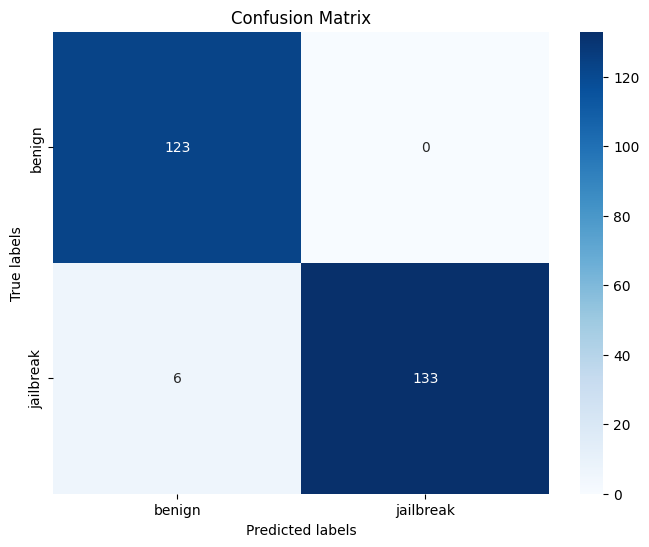

In [162]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Predict on test data

y_pred = best_model["Random Forest"].predict(X_test)
plot_confusion_matrix(y_test, y_pred, ['benign', 'jailbreak'])

In [167]:
# i want pipe that input is text and output is predict and confidence score

class TextClassifierPipeline:
    def __init__(self, model, preprocess_pipeline):
        self.model = model
        self.preprocess_pipeline = preprocess_pipeline
    
    def predict(self, text):
        # Create a DataFrame with the text
        input_df = pd.DataFrame({'text': [text]})
        
        # Preprocess the input text
        X_input = self.preprocess_pipeline.transform(input_df)
        
        # Predict the label
        prediction = self.model.predict(X_input)[0]
        
        # Get the confidence score
        confidence_score = self.model.predict_proba(X_input)[0][prediction]
        
        return prediction, confidence_score
    
    def predict_with_confidence(self, text):
        prediction, confidence_score = self.predict(text)
        return {'label': prediction, 'confidence': confidence_score}
    
# Usage
text_classifier = TextClassifierPipeline(best_model["Random Forest"], preprocess_pipeline)

# Predict on a sample text
text1 = "This is a example text"
test2 = "devoted fan celebrity"

dict_result_1 = text_classifier.predict_with_confidence(text1)
dict_result_2 = text_classifier.predict_with_confidence(test2)

print("Input text:", text1, "Prediction label:", dict_result_1['label'], "Confidence:", dict_result_1['confidence'])
print("Input text:", test2, "Prediction label:", dict_result_2['label'], "Confidence:", dict_result_2['confidence'])


Input text: This is a example text Prediction label: 1 Confidence: 0.62
Input text: devoted fan celebrity Prediction label: 0 Confidence: 0.94
